In [1]:
import numpy as np
import pandas as pd

from dsc2024 import datasets
from dsc2024 import handling

# Data Handling

In [2]:
# Parameters
sampling = None # None to use everything
real_test = False

In [3]:
%%time

if real_test:
    sampling = None
df = datasets.get_train_dataset(sampling=sampling)

dataset row:149631 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                              ^
dataset row:149639 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                              ^
dataset row:149657 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                              ^
dataset row:149673 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                              ^
dataset row:149678 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 63 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hora_ref                       211679 non-null  datetime64[ns]
 1   origem                         211679 non-null  object        
 2   destino                        211679 non-null  object        
 3   url_img_satelite               208741 non-null  object        
 4   prev_troca_cabeceira           211679 non-null  int64         
 5   troca_cabeceira_hora_anterior  211679 non-null  int64         
 6   espera                         211679 non-null  float64       
 7   metar_station_id               210043 non-null  object        
 8   metar_latitude                 210043 non-null  float64       
 9   metar_longitude                210043 non-null  float64       
 10  metar_elevation 

In [5]:
# drop columns with only has null values
df.dropna(axis=1, how="all", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 57 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hora_ref                       211679 non-null  datetime64[ns]
 1   origem                         211679 non-null  object        
 2   destino                        211679 non-null  object        
 3   url_img_satelite               208741 non-null  object        
 4   prev_troca_cabeceira           211679 non-null  int64         
 5   troca_cabeceira_hora_anterior  211679 non-null  int64         
 6   espera                         211679 non-null  float64       
 7   metar_station_id               210043 non-null  object        
 8   metar_latitude                 210043 non-null  float64       
 9   metar_longitude                210043 non-null  float64       
 10  metar_elevation 

In [6]:
# drop non-feature datetime / image columns (to be out of baseline for feature engineering)
datetime_columns = ["hora_ref", "metaf_date_time", "metar_date_time", "url_img_satelite"]
df.drop(columns=datetime_columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   origem                         211679 non-null  object 
 1   destino                        211679 non-null  object 
 2   prev_troca_cabeceira           211679 non-null  int64  
 3   troca_cabeceira_hora_anterior  211679 non-null  int64  
 4   espera                         211679 non-null  float64
 5   metar_station_id               210043 non-null  object 
 6   metar_latitude                 210043 non-null  float64
 7   metar_longitude                210043 non-null  float64
 8   metar_elevation                210043 non-null  float64
 9   metar_wind_direction           198901 non-null  float64
 10  metar_wind_speed               210039 non-null  float64
 11  metar_wind_gust                1969 non

In [7]:
X = df.drop("espera", axis=1)
y = df.espera.astype(int)

In [19]:
# probability of having espera P(espera=1) = 1.74%, extremely unbanlaced 
y.value_counts() / y.count()

espera
0    0.982587
1    0.017413
Name: count, dtype: float64

In [8]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['origem',
 'destino',
 'metar_station_id',
 'metar_current_wx1',
 'metar_current_wx2',
 'metar_current_wx3',
 'metar_skyc1',
 'metar_skyc2',
 'metar_skyc3',
 'metar_skyc4',
 'metar_remarks',
 'metaf_station_id',
 'metaf_current_wx1',
 'metaf_current_wx2',
 'metaf_skyc1',
 'metaf_skyc2',
 'metaf_remarks']

# Data Imputation

In [9]:
# Fill categorical features with unknown class (a new category)
# numerical features will be filled with min-value catboost default strategy
cat_features_fill_map = {f: "UNKNOWN" for f in cat_features}
X.fillna(cat_features_fill_map, inplace=True)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 52 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   origem                         211679 non-null  object 
 1   destino                        211679 non-null  object 
 2   prev_troca_cabeceira           211679 non-null  int64  
 3   troca_cabeceira_hora_anterior  211679 non-null  int64  
 4   metar_station_id               211679 non-null  object 
 5   metar_latitude                 210043 non-null  float64
 6   metar_longitude                210043 non-null  float64
 7   metar_elevation                210043 non-null  float64
 8   metar_wind_direction           198901 non-null  float64
 9   metar_wind_speed               210039 non-null  float64
 10  metar_wind_gust                1969 non-null    float64
 11  metar_visibility               210025 n

# Data Split Train/Test

In [11]:
from sklearn.model_selection import train_test_split
random_state = 42
X_base_train, X_test, y_base_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
X_train, X_eval, y_train, y_eval = train_test_split(X_base_train, y_base_train, test_size=1/8, random_state=random_state)

In [12]:
# real test -> to submit to kaggle, replace X_test from unlabelled samples and resplit train/eval dataset
# WARNING: in this mode, metrics report and confusion matrix are not reliable, since it trained with all data. So they are not show.
if real_test:
    # TODO: move this data handling to be by default at datasets.get_public_dataset()

    # data handling
    df_real_test = datasets.get_test_dataset()    
    df_real_test.dropna(axis=1, how="all", inplace=True)
    df_real_test.drop(columns=datetime_columns, inplace=True)
    X_test = df_real_test
    X_test.fillna(cat_features_fill_map, inplace=True)

    # split
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.20, random_state=random_state)

# Add graph Features

In [13]:
from dsc2024 import features
X_train = features.generate_graph_features(X_train)
X_test = features.graph_features_testdata(X_test, X_train)
X_eval = features.graph_features_testdata(X_eval, X_train)

In [28]:
# computer class weights
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_0 = class_weights[0]
class_weights = class_weights / class_0

# Training model

In [37]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(
   data=X_train,
   label=y_train,
   cat_features=cat_features
)

# metric = "TotalF1:average=Macro;use_weights=False"
eval_metric = "Logloss"
metric = "F1:use_weights=false"
model = CatBoostClassifier(
    iterations=3000,  # Maximum number of trees (you can adjust this)
    early_stopping_rounds=100,  # Number of iterations to wait for improvement
    eval_metric=eval_metric,  # Metric to use for early stopping
    cat_features=cat_features,
    custom_loss=[metric],
    class_weights=class_weights, # class weights, because dataset is unbalanced
    verbose=50,  # Print information every n iterations,
    random_seed=random_state,
)

model.fit(train_data, eval_set=(X_eval, y_eval), plot=True)
y_pred = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.067537
0:	learn: 0.6797103	test: 0.6790718	best: 0.6790718 (0)	total: 183ms	remaining: 9m 8s
50:	learn: 0.5435622	test: 0.5533151	best: 0.5532961 (49)	total: 7.57s	remaining: 7m 17s
100:	learn: 0.5240794	test: 0.5443592	best: 0.5443592 (100)	total: 14.9s	remaining: 7m 7s
150:	learn: 0.5113193	test: 0.5387976	best: 0.5387976 (150)	total: 24.6s	remaining: 7m 44s
200:	learn: 0.4890247	test: 0.5350741	best: 0.5344829 (187)	total: 36.9s	remaining: 8m 33s
250:	learn: 0.4578960	test: 0.5315112	best: 0.5309177 (246)	total: 48.2s	remaining: 8m 47s
300:	learn: 0.4324218	test: 0.5334151	best: 0.5309177 (246)	total: 57.7s	remaining: 8m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5309176841
bestIteration = 246

Shrink model to first 247 iterations.


# Model evaluation

Classification Report: F1[class=1] = 0.092
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     41616
           1       0.05      0.71      0.09       720

    accuracy                           0.76     42336
   macro avg       0.52      0.74      0.48     42336
weighted avg       0.98      0.76      0.85     42336

Confusion Matrix:
[[31627  9989]
 [  206   514]]


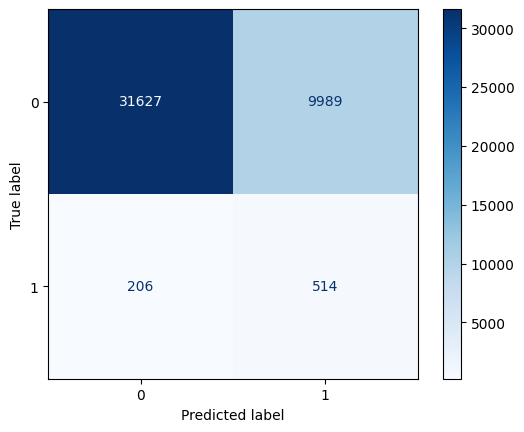

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

if not real_test:
    report = classification_report(y_test, y_pred)
    f1_score_class1 = f1_score(y_test, y_pred, average=None)
    print(f"Classification Report: F1[class=1] = {round(f1_score_class1[1], 3)}")
    print(report)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Save prediction


In [18]:
y_pred_series = pd.Series(y_pred, index=X_test.index, name="espera")
y_pred_series.to_csv(datasets.datasets_dir / "catboost_submit.csv")

In [20]:
y_pred_series.count()

42336